In [35]:
import time
import numpy as np
import matplotlib.pyplot as plt

### 1. HMC sampler

In [37]:
class standard_hmc:
    def __init__(self, q0, f):
        self.q0 = q0
        self.f = f

        self.Nq = len(q0)
        self.massinv = np.eye(self.Nq)
        self.MAX_SAMPLES = 10000

    def create_p(self):
        p = np.random.normal(loc=0, scale=1.0, size=self) 
        return p
    
    def Kp(self, p):
        '''Compute Kp, as M is identical matrix. '''
        return  0.5 * p.T @ (self.massinv @p) 
    
    def leapfrog(self, q, p, e, L):

        _, grad = self.f(q)
        for _ in range(L):  
            p = p + 1/2 * e * grad
            q = q + e * self.massinv @ p

            _, grad = self.f(q)
            p = p + 1/2 * e * grad
        return q, p
    
    def sampling(self, e, L, Msamples, Madapt):

        q = self.q0

        samples = []
        for m in range(self.MAX_SAMPLES):
            if len(samples) >= Msamples + Madapt:
                break
    
            # update q and p
            p = self.create_p(self.Nq)
            current_q = q
            current_p = p
            new_q, new_p = self.leapfrog(current_q, current_p, e, L)
            #print(current_q, new_q)
            # calculate Hamiltonian from potential energy and kinetic energy
            logp, _ = self.f(current_q)
            current_U = -logp
            current_K = self.Kp(current_p)
    
            logp_new, _ = self.f(new_q)
            new_U = -logp_new
            new_K = self.Kp(new_p)
    
            # determine whether accept the proposed sample or not
            denergy = current_U - new_U + current_K - new_K
            acceptance_prob = min(0, denergy)
            alpha = np.log(np.random.rand())
        
            if alpha < acceptance_prob:
                q = new_q
                samples.append(q)
            else:
                q = current_q
    
        print('Acceptance_rate = {}'.format(len(samples)/m))
        return np.array(samples)[Madapt:]

#### 1.2 Choose function

In [38]:
def logp(x):
    return -0.5 * np.sum(x**2)

def grad(x):
    return -x

def target_density(x):
    return np.exp(-0.5 * np.sum(x**2))

def f(x):
    return logp, grad

'''
def logp(q):
    return -0.5 * (q[0]**2 + q[1]**2)


def grad(q):
    grad = np.zeros(2)
    grad[0] = -q[0] 
    grad[1] = -q[1]    
    return grad

def target_density(q):
    return (1 / (2 * np.pi)) * np.exp(-0.5 * (q[0]**2 + q[1]**2))
'''

'\ndef logp(q):\n    return -0.5 * (q[0]**2 + q[1]**2)\n\n\ndef grad(q):\n    grad = np.zeros(2)\n    grad[0] = -q[0] \n    grad[1] = -q[1]    \n    return grad\n\ndef target_density(q):\n    return (1 / (2 * np.pi)) * np.exp(-0.5 * (q[0]**2 + q[1]**2))\n'

### 2. Visualization

#### 2.1 posterior density distribution and true distribution

In [19]:
def plot_prediction(samples, target_density=target_density,save_file=None):

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 2], height_ratios=[2, 2], wspace=0.15, hspace=0.15)

    ax1 = fig.add_subplot(gs[0, 0])
    # generate grids
    x = np.linspace(-2, 6, 100)
    y = np.linspace(-2, 6, 100)
    X, Y = np.meshgrid(x, y)

    # compute the posterior density
    Z = target_density([X,Y])

    # plot samples

    ax1.plot(samples[:, 0], samples[:, 1], 'r+')
    # plot contour
    contour = plt.contour(X, Y, Z, cmap='viridis')
    ax1.clabel(contour, inline=1, fontsize=10)
    ax1.annotate(f'#Samples: {len(samples)}', xy=(5, 5), xytext=(5, 5),
                       ha='center', va='bottom')


    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.set_xlabel("x-samples")
    ax2.set_ylabel("density")
    data = samples[:,0]
    mu, sigma = np.mean(data), np.std(data)
    '''
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    gaussian = norm.pdf(x, mu, sigma)
    ax2.plot(x, gaussian, color='red', label='Gaussian Distribution')
    '''
    ax2.hist(data, bins=20,color='k',edgecolor='k',density=True, alpha=0.5)
    ax2.set_title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
    ax2.xaxis.set_tick_params(labelleft=False)


    ax3 = fig.add_subplot(gs[0, 1], sharey=ax1) 
    ax3.set_ylabel("y-samples")
    ax3.set_xlabel("density")
    data = samples[:,1]
    mu, sigma = np.mean(data), np.std(data)
    '''
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    gaussian = norm.pdf(x, mu, sigma)
    ax3.plot(x, gaussian, color='red', label='Gaussian Distribution')
    '''
    ax3.hist(data, bins=20,color='k',edgecolor='k',alpha=0.5,density=True, orientation='horizontal')
    ax3.set_title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
    ax3.yaxis.set_tick_params(labelleft=False)

    ax_blank = fig.add_subplot(gs[1, 1])
    ax_blank.axis('off')

    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)
    else:
        plt.show()


#### 2.2 Convergency speed

1. ACF(Autocorrelation Function) 自相关函数是一个用于评估样本独立性和质量的一个重要工具：\
如果ACF快速下降到零，说明样本之间的独立性较高；
反之，样本之间存在较高的自相关性，样本独立性较低。
2. ACF 可以用来计算有效样本大小（Effective Samples Size, ESS)，其计算公式为 $ESS = M/\tau$，其中M是总样本数，$\tau$是集成自相关时间（integrated autocorrelation time），其定义为: \
   $\tau = 1+2*\sum_{k=1}^{M_{cutoff}} (1- \frac{s}{M}) \rho_k$; $M_{cutoff} = min s$, $s.t. \rho < 0.05$ \
   $\rho = \frac{1}{\sigma^2 (M-s)} \sum_{m=s+1}^{M}(f(\theta^m)-\mu)(f(\theta^{m-s})-\mu)$
   where $\sigma^2$ is the mean of f and $\mu$ is the variance of f

In [13]:
def autocorrelation(chain, lag):
    M = len(chain)
    mean = np.mean(chain)
    var = np.sum((chain - mean) ** 2) / M
    return np.sum((chain[:M-lag] - mean) * (chain[lag:] - mean)) / (M - lag) / var

def autocorrelation_function(chain, max_lag):
    return np.array([autocorrelation(chain, lag) for lag in range(max_lag)])

def integrated_autocorrelation_time(autocorr, M):
    # Use a cutoff when autocorrelation lower than 0.05
    cuttoff_autocorr = autocorr[autocorr > 0.05]
    M_cutoff = len(cuttoff_autocorr)

    sum = 0
    for s in range(M_cutoff):
        sum += cuttoff_autocorr[s] * (1 - s/M)
    
    return 1 + 2 * sum

def effective_sample_size(chain, max_lag):
    M = len(chain)
    autocorr = autocorrelation_function(chain, max_lag)
    tau = integrated_autocorrelation_time(autocorr, M)
    ess = M / tau
    return ess 

# 可视化自相关函数
def plot_autocorrelation(chain, max_lag, label,save_file=None):
    fig = plt.figure(figsize=(10, 10))
    autocorr = autocorrelation_function(chain, max_lag)
    lags = np.arange(max_lag)
    
    plt.figure(figsize=(10, 5))
    plt.stem(lags, autocorr, linefmt='lightblue')
    plt.xlabel('Lag')
    plt.ylabel(f'{label} Autocorrelation')
    plt.title('Autocorrelation Function')
    plt.axhline(y=0.05, color='g', linestyle='--', linewidth=1)
    plt.axhline(y=-0.05, color='g', linestyle='--', linewidth=1)
    plt.grid(True)
    if save_file:
        plt.savefig(save_file)
    else:
        plt.show()

#### 2.3 Log likelihood function, truth value and predicted mean value

In [14]:
def plot_loglikelihood(A, alpha,save_file=None):

    fig = plt.figure(figsize=(10, 10))
    alpha = 0
    # Print Monte-Carlo estimate of alpha.
    print("Mean:  " + str(np.mean(A)))
    per = np.percentile(A, [16, 50, 84])
    print("Alpha = {} (+{} / - {})".format( per[1], per[2] - per[1], per[1] - per[0] ))

    n, b = np.histogram(A, 30)
    x = 0.5 * (b[:-1] + b[1:])
    y = n.astype(float) / n.sum()
    plt.step(x, y, color='b', lw=3, where='mid')


    ylim = plt.ylim()
    plt.vlines(alpha, 0, ylim[1], color='r', lw=3)
    plt.vlines(per, 0., max(y), linestyle='--', color='b', lw=1)
    plt.ylim(ylim)
    plt.xlabel(r'$\alpha$', fontsize=24)
    plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=24)
    if save_file:
        plt.savefig(save_file)
    else:
        plt.show()

# Initialization

For each method, we drew 5000 sample safter 1000 burn-in samples.

In [33]:
Nq = 2
q0 = np.random.normal(0, 1, Nq)
#q0=x0 = np.array([5.2,0.5,1.03])
# tunning hyperparameters: step size, the number of steps, mass matrix
epsilon = 0.05
L = 20

n_samples = 500
n_adapt = 100

print("==============Start Sampling=============")
t_start = time.time()
hmc = standard_hmc(q0,f)
samples = hmc(q0, epsilon, L, n_samples, n_adapt, logp=logp, grad=grad)

t_stop = time.time()
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))



==============Start Sampling=============
Acceptance_rate = 1.0
Sampling Completed in 0.06 seconds


In [34]:
samples

array([[ 1.38672880e+00,  1.36939789e-02],
       [ 1.01405759e+00, -3.74393042e-02],
       [-2.44748403e-01, -3.82947013e-01],
       [ 9.48314359e-02, -1.23394749e-01],
       [ 2.76240100e-01, -9.03901552e-01],
       [ 4.63440290e-01, -8.64494719e-01],
       [-3.72880203e-02, -8.59461629e-01],
       [-6.59434236e-01, -1.01180785e+00],
       [ 1.00726109e+00, -8.01819080e-01],
       [ 1.49428434e+00,  9.93195380e-01],
       [ 1.24318601e+00,  3.61525306e-01],
       [ 3.18269410e-01, -7.98332431e-02],
       [ 1.33824840e+00,  7.53980062e-01],
       [ 1.28070823e+00, -8.20961956e-01],
       [-4.59781456e-01,  7.29444393e-02],
       [-1.48028446e+00,  9.50469042e-01],
       [-1.92504862e+00, -1.05590297e+00],
       [-1.47482382e-04,  2.12662084e-01],
       [-9.71911066e-02, -1.70738059e-01],
       [ 9.15332542e-01, -7.05290634e-01],
       [-9.93443826e-02, -3.20949418e-01],
       [ 1.44733841e+00,  7.38846321e-01],
       [-3.91989248e-01, -1.35851428e+00],
       [ 1.

# Visualization

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

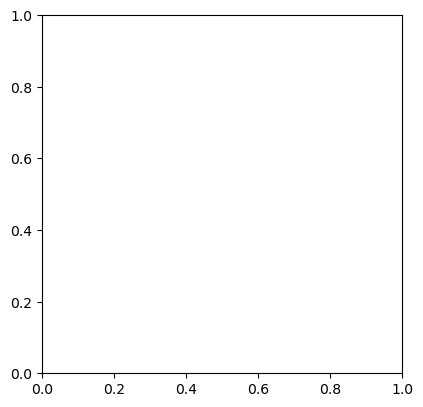

In [20]:

# visualization
plot_prediction(samples, target_density, save_file = '/Users/gangyang/Desktop/figs/1.png')
plot_loglikelihood(samples[:,0], 1, save_file = '/Users/gangyang/Desktop/figs/2.png')

plot_loglikelihood(samples[:,1], 1, save_file = '/Users/gangyang/Desktop/figs/3.png')

# 最大滞后时间
max_lag = 1000

#  parameter 1
data = samples[:,0]
ess = effective_sample_size(data, max_lag)
print("Effective Sample Size (ESS):", ess)
plot_autocorrelation(data, max_lag, label='Param1', save_file = '/Users/gangyang/Desktop/figs/4.png')
fig = plt.figure(figsize=(10, 10))
plt.plot(data, label='Param1')
plt.legend()
plt.savefig('/Users/gangyang/Desktop/figs/5.png')


#  parameter 2
data = samples[:,1]
ess = effective_sample_size(data, max_lag)
print("Effective Sample Size (ESS):", ess)
plot_autocorrelation(data, max_lag, label='Param2', save_file = '/Users/gangyang/Desktop/figs/6.png')

#### sample trace plot for a signle run
fig = plt.figure(figsize=(10, 10))
plt.plot(data, label='Param2')
plt.legend()
plt.savefig('/Users/gangyang/Desktop/figs/7.png')